In [59]:
import requests
import pandas as pd
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL do novo arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="Séries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # Lê como string para evitar conversões erradas
    )

    # Converter colunas numéricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as três primeiras colunas (Sigla, Código, Município)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem notação científica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,20776771,8562961,11362390,11235470,14613649,15877934,9088736,8996591,6580221,4908745
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,3197656,35660,334018,5179684,1636721,924183,297710,524263,112330,151097
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,8906259,9917391,16527385,13863737,11236307,10363271,7850346,3423072,3098155,3913477
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,16035479,18792652,9158576,10670679,17666324,14845991,6806347,9281610,4009833,3910707
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,4519761,3421325,4075607,3578121,11337150,6119740,3826153,2452279,6232797,3550908


In [60]:
# Identificar as colunas de anos (ignorar as colunas categóricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome numérico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano disponível na base
df["Data_Final"] = int(max(colunas_anos))    # Último ano disponível na base

# Criar a coluna de Recência (R)
def calcular_recencia(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque maior que 0

    if anos_validos:
        return df["Data_Final"].iloc[0] - max(anos_validos)  # Último ano de estoque - Data Final
    return df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0]  # Caso não tenha estoque, pega o período total

df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequência (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monetário (M) - Soma total dos estoques ao longo do período
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Exibir os dados processados para verificar se está condizente
df.head()


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2019,2020,2021,2022,2023,Data_Inicial,Data_Final,Recencia,Frequencia,Monetario
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,15877934,9088736,8996591,6580221,4908745,1993,2023,0,29,231741082
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,924183,297710,524263,112330,151097,1993,2023,0,29,41216925
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,10363271,7850346,3423072,3098155,3913477,1993,2023,0,31,177560391
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,14845991,6806347,9281610,4009833,3910707,1993,2023,0,29,257391191
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,6119740,3826153,2452279,6232797,3550908,1993,2023,0,26,98085601


In [61]:
# Criar uma cópia do dataframe para os cálculos LFM
rfm = df.copy()

# Garantir que a coluna "Municipio" seja preservada
rfm["Municipio"] = df["Município"]  # Verifique se o nome tem acento, pode ser "Município" ou "Municipio"

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o último ano com crédito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Anos em que o município pegou crédito

    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # Último ano - Primeiro ano
    return 0  # Caso nunca tenha pego crédito

rfm["Longevidade"] = rfm.apply(calcular_longevidade, axis=1)

# Criar scores LFM por quintis (de 1 a 5)
rfm["score_L"] = pd.qcut(rfm["Longevidade"], 5, labels=False, duplicates="drop") + 1
rfm["score_R"] = pd.qcut(-rfm["Recencia"], 5, labels=False, duplicates="drop") + 1  # Mantendo score_R original
rfm["score_F"] = pd.qcut(rfm["Frequencia"], 5, labels=False, duplicates="drop") + 1
rfm["score_M"] = pd.qcut(rfm["Monetario"], 5, labels=False, duplicates="drop") + 1

# Criar um score médio entre Frequência e Monetário
rfm["score_FM"] = (rfm["score_F"] + rfm["score_M"]) / 2

# Converter score_FM para inteiro
rfm["score_FM"] = rfm["score_FM"].astype(int)

# Reordenar as colunas conforme a necessidade
colunas_anos = [col for col in df.columns if col.isdigit()]  # Pegar colunas numéricas dos anos
colunas_finais = ["Municipio", "Data_Inicial", "Data_Final", "Longevidade", "Recencia", "Frequencia", "Monetario", "score_L", "score_R", "score_F", "score_M", "score_FM"]

# Ordenar dataframe conforme desejado, mantendo "Municipio"
rfm = rfm[["Municipio"] + colunas_anos + colunas_finais]

# Exportar o arquivo para Excel
rfm.to_excel("/content/segmentacao_LFM_credito_rural.xlsx", index=False, engine="openpyxl")

# Exibir os dados segmentados
rfm.head(30)


,Municipio,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,Data_Final,Longevidade,Recencia,Frequencia,Monetario,score_L,score_R,score_F,score_M,score_FM
0,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,8959974,3940040,...,2023,28,0,29,231741082,1,1,2,4,3
1,Assis Brasil,125701,1764378,294535,0,0,244387,688827,249883,943595,...,2023,30,0,29,41216925,2,1,2,2,2
2,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,2914873,4408776,...,2023,30,0,31,177560391,2,1,2,4,3
3,Bujari,0,0,569863,13844,108046,293693,635708,4778237,9029253,...,2023,28,0,29,257391191,1,1,2,4,3
4,Capixaba,0,0,0,0,104771,560449,0,466463,2098383,...,2023,26,0,26,98085601,1,1,1,3,2
5,Cruzeiro do Sul,4174121,9793970,2930975,740449,45919,25763,4497267,6595863,756518,...,2023,30,0,31,73294608,2,1,2,3,2
6,Epitaciolândia,0,0,0,0,17272,0,691557,1276425,1006598,...,2023,26,0,26,62018956,1,1,1,3,2
7,Feijó,157460,736830,0,1741801,606447,152267,1598423,986712,1981464,...,2023,30,0,30,64958872,2,1,2,3,2
8,Jordão,0,0,0,0,0,0,0,114865,0,...,2023,23,0,14,1310817,1,1,1,1,1
9,Mâncio Lima,0,0,0,0,0,0,45506,1128672,544694,...,2023,24,0,25,17574727,1,1,1,1,1


In [62]:
import requests
import pandas as pd
import numpy as np
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Garantir que a coluna "Municipio" esteja no DataFrame antes da segmentação
if "Municipio" not in rfm.columns:
    rfm["Municipio"] = df["Municipio"]  # Verifique se é "Município" com acento!

# Normalizar os dados antes do PCA
scaler = StandardScaler()
df_scaled_pca = scaler.fit_transform(rfm[["Frequencia", "Monetario", "Longevidade"]])

# Aplicar PCA para redução de dimensionalidade
pca = PCA()
pca_result = pca.fit_transform(df_scaled_pca)

# Criar a coluna de ranking LFM com base no primeiro componente principal (PCA)
rfm["ranking_LFM"] = np.argsort(-pca_result[:, 0])

# Aplicar K-Means com mais clusters para refinar a segmentação
kmeans = KMeans(n_clusters=7, n_init=25, random_state=123)
rfm["cluster"] = kmeans.fit_predict(df_scaled_pca)

# Criar um escore composto para segmentação
rfm["score_composto"] = (rfm["score_L"] * 1.5) + (rfm["score_F"] * 1.2) + (rfm["score_M"] * 1.0)

# Definir faixas dinâmicas com base na distribuição real dos dados
p_composto = np.percentile(rfm["score_composto"], [20, 40, 60, 80])

# Criar novas condições de classificação
condicoes = [
    (rfm["score_composto"] > p_composto[3]),
    (rfm["score_composto"] > p_composto[2]),
    (rfm["score_composto"] > p_composto[1]),
    (rfm["score_composto"] > p_composto[0]),
    (rfm["cluster"] == 3) | (rfm["cluster"] == 4),
    (rfm["cluster"] == 5) | (rfm["cluster"] == 6),
]

categorias = [
    "Demanda de Alta Intensidade",
    "Demanda de Média-Alta Intensidade",
    "Demanda de Média Intensidade",
    "Demanda de Média-Baixa Intensidade",
    "Demanda de Baixa Intensidade",
    "Demanda de Intensidade Marginal"
]

rfm["classificacao_LFM"] = np.select(condicoes, categorias, default="Inativo")

# Reordenar as colunas incluindo "Municipio" para garantir que não seja perdido
colunas_finais = ["Municipio", "Data_Inicial", "Data_Final", "Longevidade", "Recencia", "Frequencia", "Monetario",
                  "score_L", "score_R", "score_F", "score_M", "score_FM", "ranking_LFM", "cluster",
                  "score_composto", "classificacao_LFM"]

# Manter a estrutura do DataFrame incluindo "Municipio"
rfm = rfm[["Municipio"] + colunas_anos + colunas_finais]

# Exibir os dados segmentados para verificar
rfm = rfm.loc[:, ~rfm.columns.duplicated()].copy()
rfm.head(30)


,Municipio,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,Monetario,score_L,score_R,score_F,score_M,score_FM,ranking_LFM,cluster,score_composto,classificacao_LFM
0,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,8959974,3940040,...,231741082,1,1,2,4,3,5373,0,8,Demanda de Média Intensidade
1,Assis Brasil,125701,1764378,294535,0,0,244387,688827,249883,943595,...,41216925,2,1,2,2,2,1089,0,7,Demanda de Média-Baixa Intensidade
2,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,2914873,4408776,...,177560391,2,1,2,4,3,3270,0,9,Demanda de Média-Alta Intensidade
3,Bujari,0,0,569863,13844,108046,293693,635708,4778237,9029253,...,257391191,1,1,2,4,3,4879,0,8,Demanda de Média Intensidade
4,Capixaba,0,0,0,0,104771,560449,0,466463,2098383,...,98085601,1,1,1,3,2,1680,3,6,Demanda de Baixa Intensidade
5,Cruzeiro do Sul,4174121,9793970,2930975,740449,45919,25763,4497267,6595863,756518,...,73294608,2,1,2,3,2,553,0,8,Demanda de Média Intensidade
6,Epitaciolândia,0,0,0,0,17272,0,691557,1276425,1006598,...,62018956,1,1,1,3,2,4506,3,6,Demanda de Baixa Intensidade
7,Feijó,157460,736830,0,1741801,606447,152267,1598423,986712,1981464,...,64958872,2,1,2,3,2,3400,0,8,Demanda de Média Intensidade
8,Jordão,0,0,0,0,0,0,0,114865,0,...,1310817,1,1,1,1,1,2412,1,4,Inativo
9,Mâncio Lima,0,0,0,0,0,0,45506,1128672,544694,...,17574727,1,1,1,1,1,3459,3,4,Demanda de Baixa Intensidade


Quantidade de municípios por segmento:
classificacao_LFM
Demanda de Média-Baixa Intensidade    1395
Demanda de Alta Intensidade           1052
Demanda de Média Intensidade          1007
Demanda de Média-Alta Intensidade      985
Demanda de Baixa Intensidade           792
Inativo                                320
Demanda de Intensidade Marginal         45
Name: count, dtype: int64
Crédito total concedido por segmento (%):
classificacao_LFM
Demanda de Alta Intensidade          74.689
Demanda de Baixa Intensidade          1.383
Demanda de Intensidade Marginal       0.006
Demanda de Média Intensidade          7.443
Demanda de Média-Alta Intensidade    12.677
Demanda de Média-Baixa Intensidade    3.546
Inativo                               0.256


<ipython-input-63-4e689676b500>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


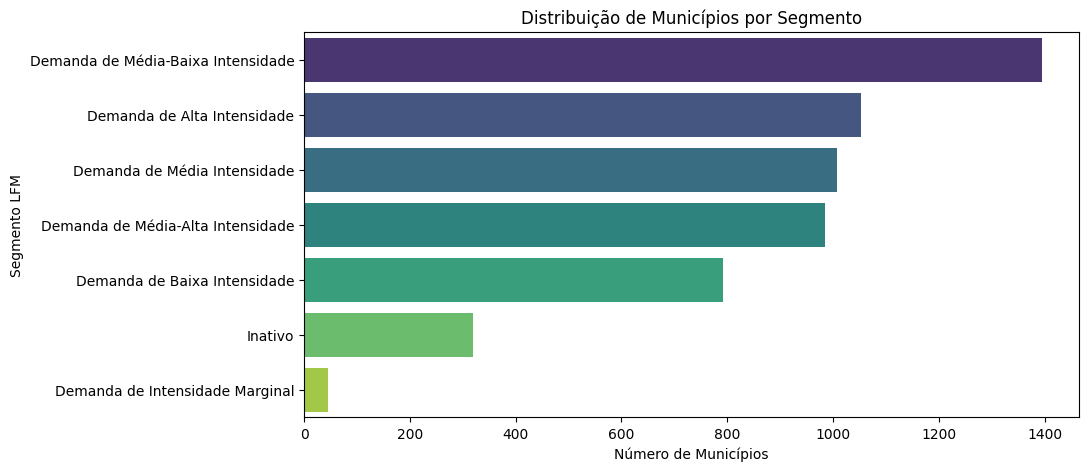

<ipython-input-63-4e689676b500>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-63-4e689676b500>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-63-4e689676b500>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
<ipython-input-63-4e689676b500>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

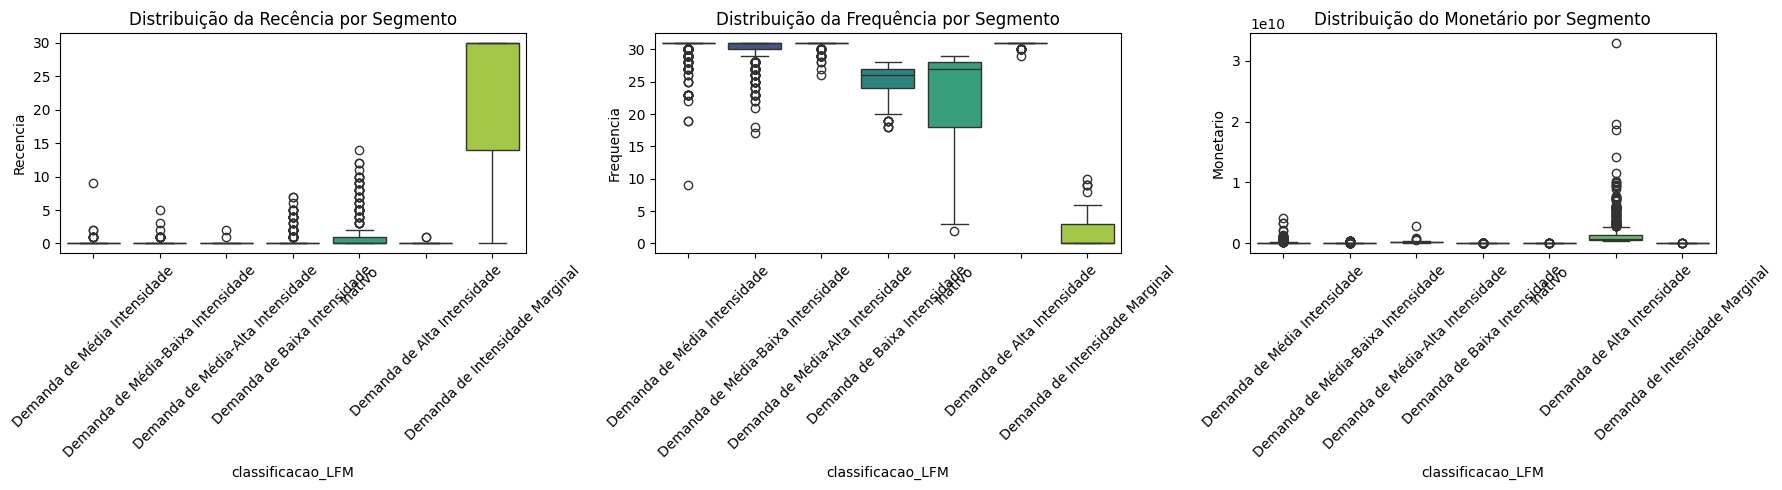

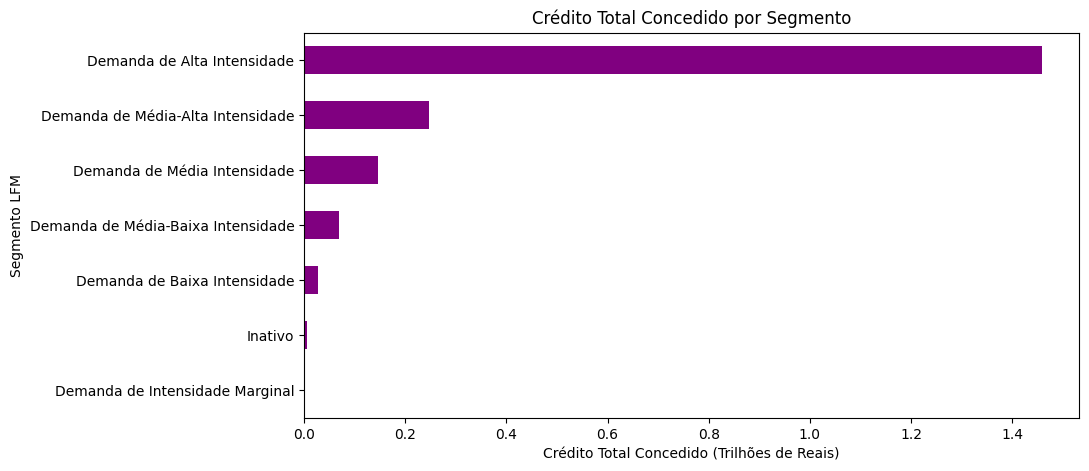

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Municípios" para uma análise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LFM"] != "Outros Municípios"]

# Contagem dos municípios por segmento
contagem_segmentos = rfm_filtrado["classificacao_LFM"].value_counts()
print("Quantidade de municípios por segmento:")
print(contagem_segmentos)

# Cálculo do crédito total concedido por segmento em porcentagem com três casas decimais
total_credito = rfm_filtrado["Monetario"].sum()
credito_por_segmento = (rfm_filtrado.groupby("classificacao_LFM")["Monetario"].sum() / total_credito) * 100

# Arredondar para três casas decimais e formatar a exibição
credito_por_segmento = credito_por_segmento.round(3)
print("Crédito total concedido por segmento (%):")
print(credito_por_segmento.to_string(float_format="%.3f"))

# 1️⃣ Gráfico de Barras - Quantidade de Municípios por Segmento
plt.figure(figsize=(10, 5))
sns.countplot(
    y=rfm_filtrado["classificacao_LFM"],
    order=rfm_filtrado["classificacao_LFM"].value_counts().index,
    palette="viridis"
)
plt.xlabel("Número de Municípios")
plt.ylabel("Segmento LFM")
plt.title("Distribuição de Municípios por Segmento")
plt.show()

# 2️⃣ Boxplot - Comparação de Recência, Frequência e Monetário por Segmento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribuição da Recência por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[1])
axes[1].set_title("Distribuição da Frequência por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.boxplot(data=rfm_filtrado, x="classificacao_LFM", y="Monetario", palette="viridis", ax=axes[2])
axes[2].set_title("Distribuição do Monetário por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 3️⃣ Crédito Total Concedido por Segmento (Monetário Total)
plt.figure(figsize=(10, 5))
(rfm_filtrado.groupby("classificacao_LFM")["Monetario"].sum() / 1e12).sort_values().plot(kind="barh", color="purple")
plt.xlabel("Crédito Total Concedido (Trilhões de Reais)")
plt.ylabel("Segmento LFM")
plt.title("Crédito Total Concedido por Segmento")
plt.show()


In [64]:
rfm.head()

,Municipio,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,Monetario,score_L,score_R,score_F,score_M,score_FM,ranking_LFM,cluster,score_composto,classificacao_LFM
0,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,8959974,3940040,...,231741082,1,1,2,4,3,5373,0,8,Demanda de Média Intensidade
1,Assis Brasil,125701,1764378,294535,0,0,244387,688827,249883,943595,...,41216925,2,1,2,2,2,1089,0,7,Demanda de Média-Baixa Intensidade
2,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,2914873,4408776,...,177560391,2,1,2,4,3,3270,0,9,Demanda de Média-Alta Intensidade
3,Bujari,0,0,569863,13844,108046,293693,635708,4778237,9029253,...,257391191,1,1,2,4,3,4879,0,8,Demanda de Média Intensidade
4,Capixaba,0,0,0,0,104771,560449,0,466463,2098383,...,98085601,1,1,1,3,2,1680,3,6,Demanda de Baixa Intensidade


/usr/local/lib/python3.11/dist-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


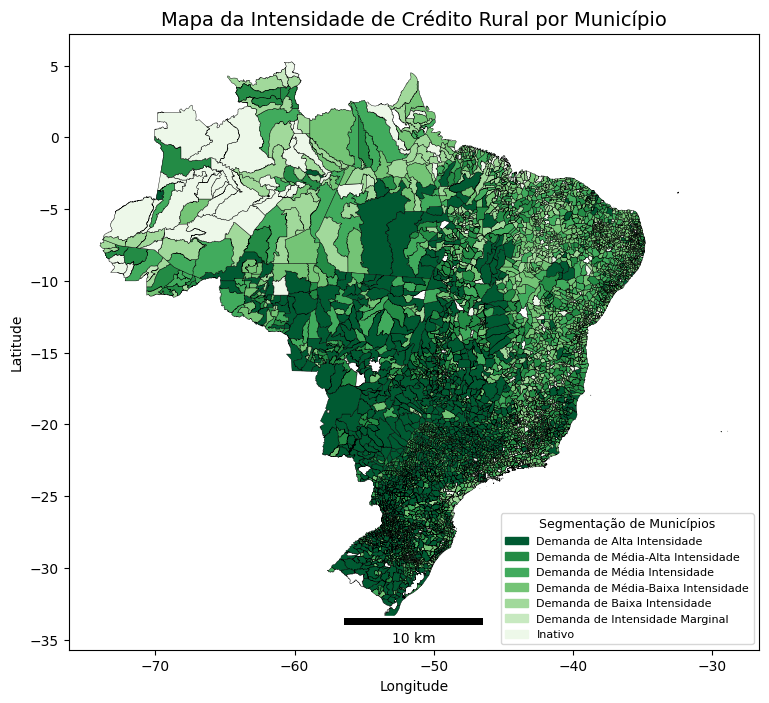

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import rcParams

# Caminho do shapefile
shapefile_path = "/content/BR_Municipios_2023.shp"

# Carregar o shapefile
brasil = gpd.read_file(shapefile_path)

# Criar um DataFrame apenas com os municípios e sua classificação segmentada
rfm_mapa = rfm[["Municipio", "classificacao_LFM"]].copy()

# Normalizar os nomes dos municípios para garantir a fusão correta
target_column = "NM_MUN"
rfm_mapa["Municipio"] = rfm_mapa["Municipio"].str.lower()
brasil[target_column] = brasil[target_column].str.lower()

# Juntar os dados ao shapefile do Brasil
brasil = brasil.merge(rfm_mapa, left_on=target_column, right_on="Municipio", how="left")

# Criar a paleta de cores
segmento_cores = {
    "Demanda de Alta Intensidade": "#005a32",
    "Demanda de Média-Alta Intensidade": "#238b45",
    "Demanda de Média Intensidade": "#41ab5d",
    "Demanda de Média-Baixa Intensidade": "#74c476",
    "Demanda de Baixa Intensidade": "#a1d99b",
    "Demanda de Intensidade Marginal": "#c7e9c0",
    "Inativo": "#edf8e9"
}

# Aplicar cores
brasil["cor_segmento"] = brasil["classificacao_LFM"].map(segmento_cores)
brasil["cor_segmento"] = brasil["cor_segmento"].fillna("#FFFFFF")

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar o mapa
brasil.plot(ax=ax, color=brasil["cor_segmento"], edgecolor="black", linewidth=0.3)

# Adicionar a escala gráfica personalizada sem rótulo
scalebar = ScaleBar(
    1, units='km', location='lower center', scale_loc='bottom', length_fraction=0.25,
    label=None
)
ax.add_artist(scalebar)

# Configurar título e legenda
plt.title("Mapa da Intensidade de Crédito Rural por Município", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Criar a legenda manualmente
legenda_patches = [mpatches.Patch(color=cor, label=segmento) for segmento, cor in segmento_cores.items()]
plt.legend(
    handles=legenda_patches,
    title="Segmentação de Municípios",
    loc="lower right",
    fontsize=8,
    title_fontsize=9,
    frameon=True
)

# Exibir o mapa
plt.show()


Valores ausentes na coluna de cor:
Empty GeoDataFrame
Columns: [CD_MUN, NM_MUN, CD_RGI, NM_RGI, CD_RGINT, NM_RGINT, CD_UF, NM_UF, CD_REGIAO, NM_REGIAO, CD_CONCURB, NM_CONCURB, AREA_KM2, geometry, Municipio, classificacao_LFM, cor_segmento]
Index: []


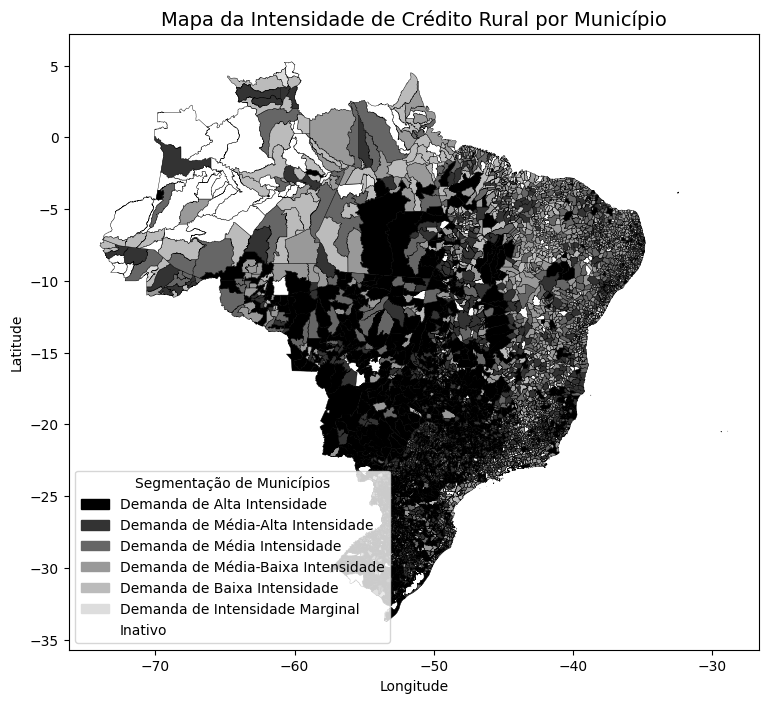

In [65]:
# Criar a coluna de cores com base na classificação e substituir NaN por branco
brasil["cor_segmento"] = brasil["classificacao_LFM"].map(segmento_cores)
brasil["cor_segmento"] = brasil["cor_segmento"].fillna("#FFFFFF")  # Substitui NaN por branco

# Verificar se ainda há valores NaN
print("Valores ausentes na coluna de cor:")
print(brasil[brasil["cor_segmento"].isna()])

# Criar o mapa
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar os municípios com cores de acordo com a classificação
brasil.plot(ax=ax, color=brasil["cor_segmento"], edgecolor="black", linewidth=0.3)

# Configurar título e legenda
plt.title("Mapa da Intensidade de Crédito Rural por Município", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Criar a legenda manualmente
import matplotlib.patches as mpatches

legenda_patches = [mpatches.Patch(color=cor, label=segmento) for segmento, cor in segmento_cores.items()]
plt.legend(handles=legenda_patches, title="Segmentação de Municípios", loc="lower left", fontsize=10)

# Exibir o mapa
plt.show()


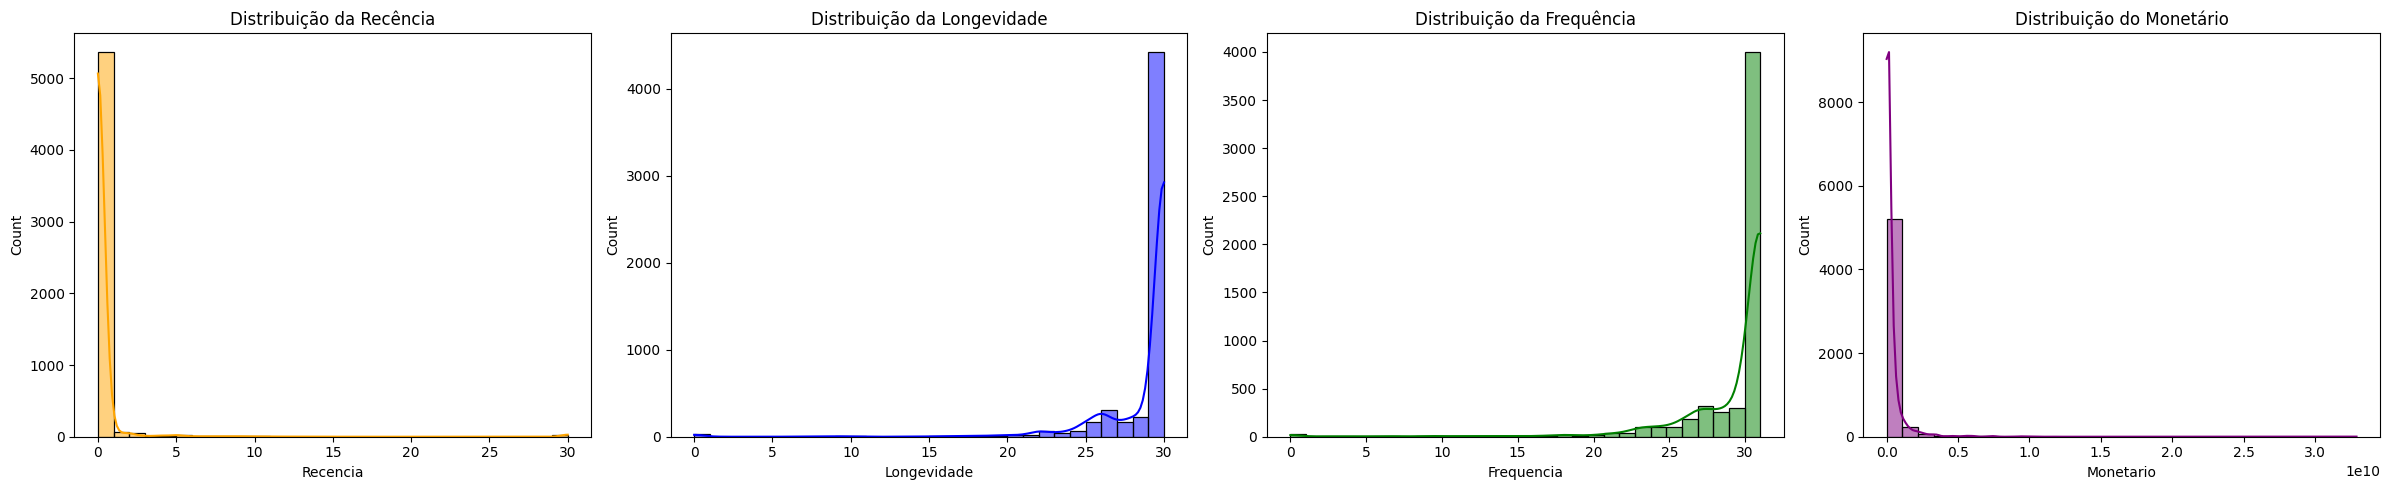

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para Recência, Longevidade, Frequência e Monetário no modelo LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.histplot(rfm["Recencia"], bins=30, kde=True, ax=axes[0], color="orange")
axes[0].set_title("Distribuição da Recência")

sns.histplot(rfm["Longevidade"], bins=30, kde=True, ax=axes[1], color="blue")
axes[1].set_title("Distribuição da Longevidade")

sns.histplot(rfm["Frequencia"], bins=30, kde=True, ax=axes[2], color="green")
axes[2].set_title("Distribuição da Frequência")

sns.histplot(rfm["Monetario"], bins=30, kde=True, ax=axes[3], color="purple")
axes[3].set_title("Distribuição do Monetário")

plt.tight_layout()
plt.show()


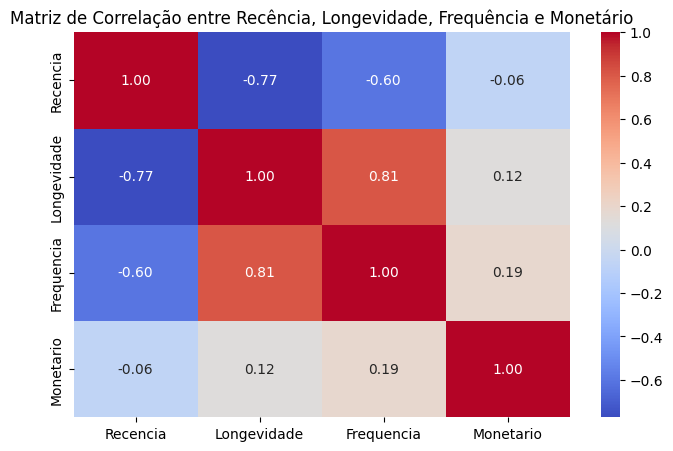

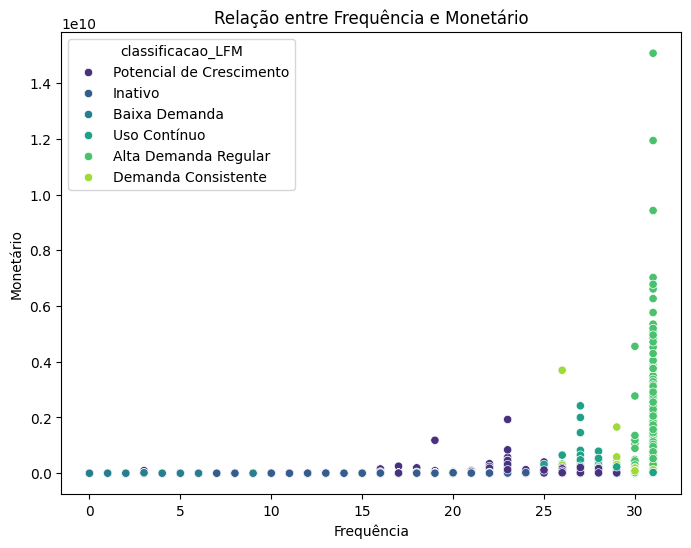

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔥 1️⃣ Matriz de Correlação com Recência, Longevidade, Frequência e Monetário
plt.figure(figsize=(8, 5))
sns.heatmap(
    rfm[["Recencia", "Longevidade", "Frequencia", "Monetario"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Matriz de Correlação entre Recência, Longevidade, Frequência e Monetário")
plt.show()

# 🔥 2️⃣ Scatterplot entre Frequência e Monetário, agora considerando LRFM
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm, x="Frequencia", y="Monetario", hue="classificacao_LFM", palette="viridis"
)
plt.title("Relação entre Frequência e Monetário")
plt.xlabel("Frequência")
plt.ylabel("Monetário")
plt.show()


<ipython-input-8-4f7a42501c6b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
<ipython-input-8-4f7a42501c6b>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-8-4f7a42501c6b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[1])
<ipython-input-8-4f7a42501c6b>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

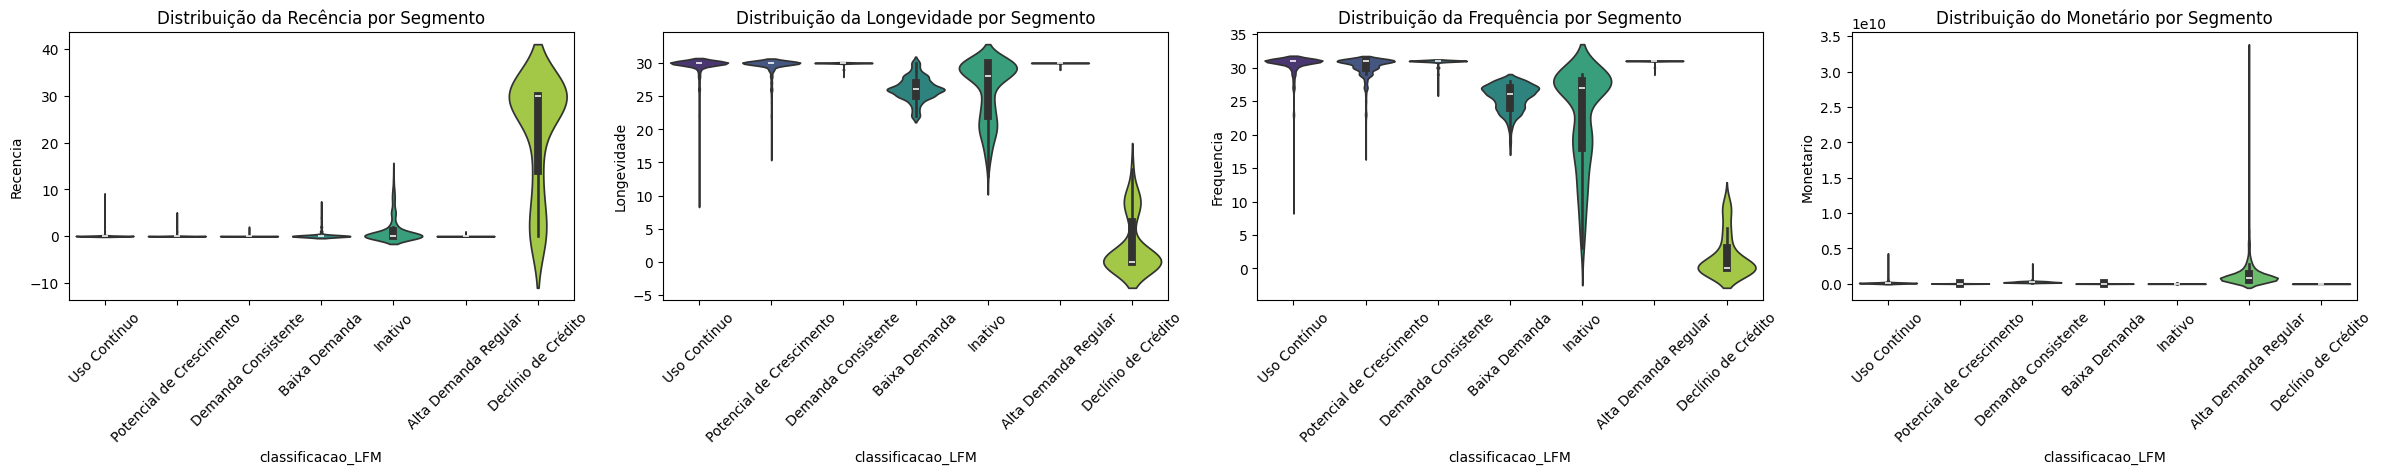

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando subplots para visualizar a distribuição das métricas por segmento LRFM
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

sns.violinplot(data=rfm, x="classificacao_LFM", y="Recencia", palette="viridis", ax=axes[0])
axes[0].set_title("Distribuição da Recência por Segmento")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Longevidade", palette="viridis", ax=axes[1])
axes[1].set_title("Distribuição da Longevidade por Segmento")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Frequencia", palette="viridis", ax=axes[2])
axes[2].set_title("Distribuição da Frequência por Segmento")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

sns.violinplot(data=rfm, x="classificacao_LFM", y="Monetario", palette="viridis", ax=axes[3])
axes[3].set_title("Distribuição do Monetário por Segmento")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


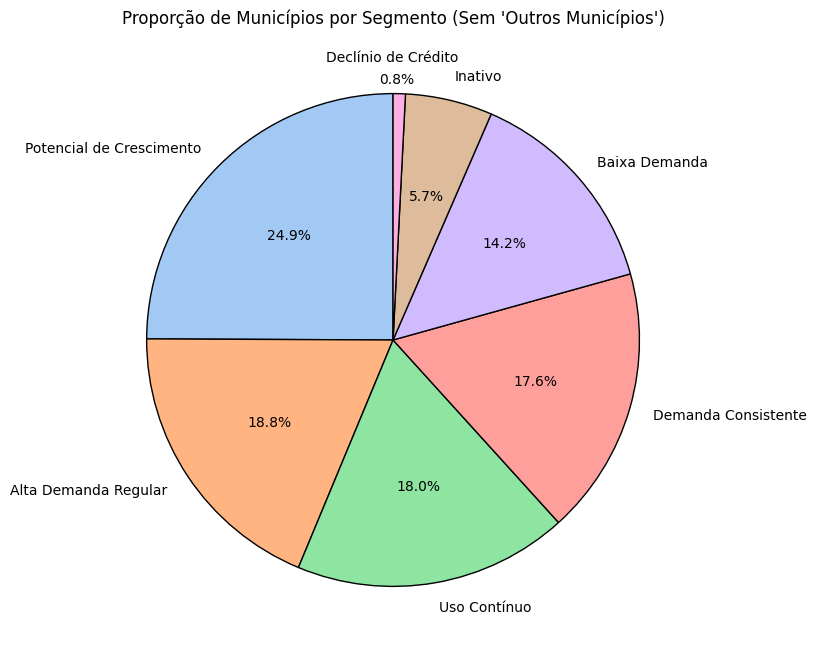

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar dados removendo "Outros Municípios" para uma análise mais relevante
rfm_filtrado = rfm[rfm["classificacao_LFM"] != "Outros Municípios"]

# Contagem dos segmentos para plotagem
segment_counts = rfm_filtrado["classificacao_LFM"].value_counts()

# Criar gráfico de pizza
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
    startangle=90,
    wedgeprops={"edgecolor": "black"}
)

# Ajustar manualmente a posição do rótulo e porcentagem de "Declínio de Crédito"
for i, text in enumerate(texts):
    if text.get_text() == "Declínio de Crédito":
        text.set_y(text.get_position()[1] + 0.05)  # Mantém o rótulo um pouco acima
        text.set_x(text.get_position()[0] - 0.3)  # Move o rótulo um pouco para a esquerda
        percent_text = autotexts[i]

        # Move a porcentagem exatamente para cima da fatia rosa
        percent_text.set_y(text.get_position()[1] - 0.09)

# Título do gráfico
plt.title("Proporção de Municípios por Segmento (Sem 'Outros Municípios')")
plt.ylabel("")  # Remove o rótulo do eixo Y
plt.show()


In [ ]:
from scipy.stats import f_oneway, levene
import pandas as pd

# Definir variáveis para análise estatística no modelo LFM
variaveis = ["Recencia", "Longevidade", "Frequencia", "Monetario"]

# Criar dicionários para armazenar os resultados
resultados_anova = {}
resultados_levene = {}

# Calcular ANOVA e Teste de Levene para cada variável considerando os clusters
for var in variaveis:
    grupos = [rfm[var][rfm["cluster"] == i] for i in rfm["cluster"].unique()]
    resultados_anova[var] = f_oneway(*grupos)
    resultados_levene[var] = levene(*grupos)

# Criar DataFrame com os resultados
resultados_df = pd.DataFrame({
    "ANOVA_F": [resultados_anova[var].statistic for var in variaveis],
    "ANOVA_p": [resultados_anova[var].pvalue for var in variaveis],
    "Levene_F": [resultados_levene[var].statistic for var in variaveis],
    "Levene_p": [resultados_levene[var].pvalue for var in variaveis]
}, index=variaveis)

# Ajustar a exibição dos valores em notação científica forçada
pd.set_option("display.float_format", lambda x: f"{x:.5e}")  # Exibir 50 casas decimais em notação científica

# Exibir resultados
print("Resultados dos Testes ANOVA e Levene (Com Precisão Extrema para p-value):")
print(resultados_df)


Resultados dos Testes ANOVA e Levene (Com Precisão Extrema para p-value):
                ANOVA_F     ANOVA_p    Levene_F    Levene_p
Recencia    2.35024e+03 0.00000e+00 4.32768e+02 0.00000e+00
Longevidade 7.55681e+03 0.00000e+00 5.47090e+02 0.00000e+00
Frequencia  6.90491e+03 0.00000e+00 4.14010e+02 0.00000e+00
Monetario   5.66632e+03 0.00000e+00 4.35052e+02 0.00000e+00


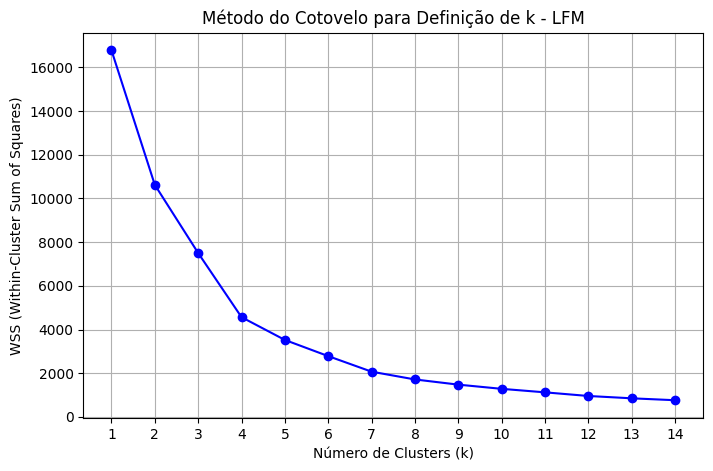

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecionar apenas as variáveis LFM para análise
X = rfm[["Longevidade", "Frequencia", "Monetario"]]

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular WSS para diferentes números de clusters
wss = []
k_values = range(1, 15)  # Testar de 1 a 15 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=123)
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)  # Soma dos quadrados intra-clusters

# Plotar o gráfico do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_values, wss, marker='o', linestyle='-', color='b')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WSS (Within-Cluster Sum of Squares)")
plt.title("Método do Cotovelo para Definição de k - LFM")
plt.xticks(k_values)
plt.grid()
plt.show()
